
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.11?urlpath=lab/tree/image_fitting_with_sherpa.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[image_fitting_with_sherpa.ipynb](../_static/notebooks/image_fitting_with_sherpa.ipynb) |
[image_fitting_with_sherpa.py](../_static/notebooks/image_fitting_with_sherpa.py)
</div>


# Fitting 2D images with Sherpa

### Introduction

Sherpa is the X-ray satellite Chandra modeling and fitting application. It enables the user to construct complex models from simple definitions and fit those models to data, using a variety of statistics and optimization methods. 
The issues of constraining the source position and morphology are common in X- and Gamma-ray astronomy. 
This notebook will show you how to apply Sherpa to CTA data.

Here we will set up Sherpa to fit the counts map and loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

This tutorial has 2 important parts
1. Generating the Maps
2. The actual fitting with sherpa.

Since sherpa deals only with 2-dim images, the first part of this tutorial shows how to prepare gammapy maps to make classical images.

### Necessary imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.cube import MapMaker, PSFKernel

### Generate the required Maps

We first generate the required maps using 3 simulated runs on the Galactic center, exactly as in the [analysis_3d](analysis_3d.ipynb) tutorial.

It is always advisable to make the maps on fine energy bins, and then sum them over to get an image.

In [2]:
# Define which data to use
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
obs_ids = [110380, 111140, 111159]
observations = data_store.get_observations(obs_ids)

In [3]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)
maps = maker.run(observations)

CPU times: user 17.8 s, sys: 1.85 s, total: 19.6 s
Wall time: 10.4 s


### Making a PSF Map

Make a PSF map and weigh it with the exposure at the source position to get a 2D PSF 

In [5]:
# mean PSF
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")

# get the exposure at the source position
exposure_at_pos = maps["exposure"].get_by_coord(
    {
        "lon": src_pos.l.value,
        "lat": src_pos.b.value,
        "energy": energy_axis.center,
    }
)

# now compute the 2D PSF
psf2D = psf_kernel.make_image(exposures=exposure_at_pos)

### Make 2D images from 3D ones

Since sherpa image fitting works only with 2-dim images,
we convert the generated maps to 2D images using `run_images()` and save them as fits files. The exposure is weighed with the spectrum before averaging (assumed to be a power law by default).


In [6]:
maps = maker.run_images()

In [7]:
Path("analysis_3d").mkdir(exist_ok=True)

maps["counts"].write("analysis_3d/counts_2D.fits", overwrite=True)
maps["background"].write("analysis_3d/background_2D.fits", overwrite=True)
maps["exposure"].write("analysis_3d/exposure_2D.fits", overwrite=True)
fits.writeto("analysis_3d/psf_2D.fits", psf2D.data, overwrite=True)

### Read the maps and store them in a sherpa model

We now have the prepared files which sherpa can read. 
This part of the notebook shows how to do image analysis using sherpa

In [8]:
import sherpa.astro.ui as sh

sh.set_stat("cash")
sh.set_method("simplex")

sh.load_image("analysis_3d/counts_2D.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "analysis_3d/exposure_2D.fits")
sh.load_table_model("bkg", "analysis_3d/background_2D.fits")
sh.load_psf("psf", "analysis_3d/psf_2D.fits")

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

In [9]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

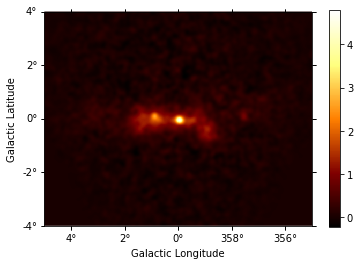

In [10]:
resid = Map.read("analysis_3d/counts_2D.fits")
resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(width=4)
resid_smooth.plot(add_cbar=True);

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [11]:
yp, xp = np.unravel_index(
    np.nanargmax(resid_smooth.data), resid_smooth.data.shape
)
ampl = resid_smooth.get_by_pix((xp, yp))[0]

# creates g0 as a gauss2d instance
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo)
g0.xpos, g0.ypos = xp, yp
sh.freeze(g0.xpos, g0.ypos)  # fix the position in the initial fitting step

# fix exposure amplitude so that typical exposure is of order unity
expo.ampl = 1e-9
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl)  # in case frozen in a previous iteration

g0.fwhm = 10  # give some reasonable initial values
g0.ampl = ampl

In [12]:
%%time
sh.fit()

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/sherpa/instrument.py:723: UserWarning: No PSF pixel size info available. Skipping check against data pixel size.
  warnings.warn("No PSF pixel size info available. Skipping check against data pixel size.")


Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 291433
Final fit statistic   = 289598 at function evaluation 230
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 1834.36
   g0.fwhm        113.287     
   g0.ampl        0.439958    
CPU times: user 11.1 s, sys: 150 ms, total: 11.2 s
Wall time: 11.2 s


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

In [13]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 289598
Final fit statistic   = 289503 at function evaluation 383
Data points           = 200000
Degrees of freedom    = 199996
Change in statistic   = 95.2247
   g0.fwhm        106.247     
   g0.xpos        234.649     
   g0.ypos        195.635     
   g0.ampl        0.478146    


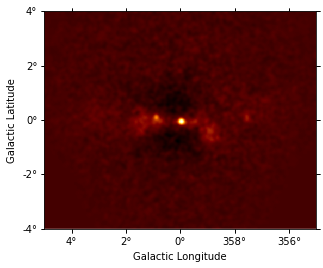

In [14]:
resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(width=3)
resid_smooth.plot();

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

In [15]:
# initialize components with fixed, zero amplitude
for i in range(1, 10):
    model = sh.create_model_component("gauss2d", "g" + str(i))
    model.ampl = 0
    sh.freeze(model)

gs = [g0, g1, g2]
sh.set_full_model(bkg + psf(g0 + g1 + g2) * expo)

In [16]:
%%time
for i in range(1, len(gs)):
    yp, xp = np.unravel_index(
        np.nanargmax(resid_smooth.data), resid_smooth.data.shape
    )
    ampl = resid_smooth.get_by_pix((xp, yp))[0]
    gs[i].xpos, gs[i].ypos = xp, yp
    gs[i].fwhm = 10
    gs[i].ampl = ampl

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    resid.data = sh.get_data_image().y - sh.get_model_image().y
    resid_smooth = resid.smooth(width=6)

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/sherpa/instrument.py:723: UserWarning: No PSF pixel size info available. Skipping check against data pixel size.
  warnings.warn("No PSF pixel size info available. Skipping check against data pixel size.")


Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 289067
Final fit statistic   = 288814 at function evaluation 214
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 253.351
   g1.fwhm        3.76114     
   g1.ampl        16.7742     
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 288814
Final fit statistic   = 288735 at function evaluation 428
Data points           = 200000
Degrees of freedom    = 199996
Change in statistic   = 79.3409
   g1.fwhm        2.13994     
   g1.xpos        253.123     
   g1.ypos        197.983     
   g1.ampl        50.184      
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 288525
Final fit statistic   = 288460 at function evaluation 223
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 64.

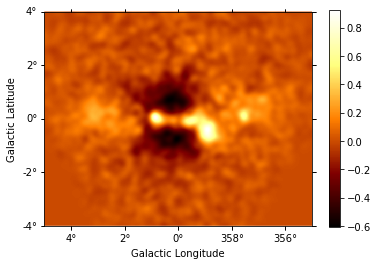

In [17]:
resid_smooth.plot(add_cbar=True);

### Generating output table and Test Statistics estimation
When adding a new source, one needs to check the significance of this new source. A frequently used method is the Test Statistics (TS). This is done by comparing the change of statistics when the source is included compared to the null hypothesis (no source ; in practice here we fix the amplitude to zero).

$TS = Cstat(source) - Cstat(no source)$

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. We have added only 3 sources to save time, but you should keep doing this till del(stat) is less than the required number.

In [18]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table

rows = []
for g in gs:
    ampl = g.ampl.val
    g.ampl = 0
    stati = sh.get_stat_info()[0].statval
    g.ampl = ampl
    statf = sh.get_stat_info()[0].statval
    delstat = stati - statf

    geom = resid.geom
    # sherpa uses 1 based indexing
    coord = geom.pix_to_coord((g.xpos.val - 1, g.ypos.val - 1))
    pix_scale = geom.pixel_scales.mean().deg
    sigma = g.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
    rows.append(
        dict(delstat=delstat, glon=coord[0], glat=coord[1], sigma=sigma)
    )

table = Table(rows=rows, names=rows[0])
for name in table.colnames:
    table[name].format = ".5g"
table

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/sherpa/instrument.py:723: UserWarning: No PSF pixel size info available. Skipping check against data pixel size.
  warnings.warn("No PSF pixel size info available. Skipping check against data pixel size.")


<Table length=3>
delstat   glon     glat    sigma  
float64 float64  float64  float64 
------- ------- --------- --------
 1825.1 0.31702 -0.097309  0.90238
 768.39  359.95 -0.050339 0.018175
 386.67  1.2962  -0.06423  0.29907

### Exercises

1. Keep adding sources till there are no more significat ones in the field. How many Gaussians do you need?
2. Use other morphologies for the sources (eg: disk, shell) rather than only Gaussian.
3. Compare the TS between different models

### More about sherpa

These are good resources to learn more about Sherpa:

* https://python4astronomers.github.io/fitting/fitting.html
* https://github.com/DougBurke/sherpa-standalone-notebooks

You could read over the examples there, and try to apply a similar analysis to this dataset here to practice.

If you want a deeper understanding of how Sherpa works, then these proceedings are good introductions:

* http://conference.scipy.org/proceedings/scipy2009/paper_8/full_text.pdf
* http://conference.scipy.org/proceedings/scipy2011/pdfs/brefsdal.pdf